In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from sympy import *
import cartopy.crs as ccrs
import cartopy as cart

import glob
import warnings
warnings.filterwarnings('ignore')

os.environ['HDF5_USE_FILE_LOCKING'] = "FALSE"
mpl.rcParams['axes.titlesize' ] = 28
mpl.rcParams['axes.labelsize' ] = 22
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["figure.figsize" ] = (30,12)
from cycler import cycler
#mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

In [2]:
### E3SM SC cases
dir_cesm2 = "/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm"
dir_esgf = dir_cesm2 + "/cesm2-waccm-esgf/"
Dir_Geo_E3SM = "/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/"
E3SM_Geo_PK20 = "20220528.PkShav1.5_GEOENG_SSP534OS_RUBISCO_NEWSFLU_CNPCTCSSP_OIBGC.ne30_oECv3.miller"
E3SM_Geo_534S = "20220522.GEOENG_SSP534OS_RUBISCO_NEWSFLU_CNPCTCSSP_OIBGC.ne30_oECv3.miller"
E3SM_Geo_HIST = "20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller"
E3SM_Org_HIST = "20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy"

In [3]:
### Common functions to deal with the output time and land_units


def open_files (DataSource, SceName, TabName, CaseName, VarName):
# read files from three different data source, ncar(cesm2-waccm), esgf, and e3sm
    import os
    if DataSource == 'ncar':
        TopDir = dir_cesm2
        
        if TabName == 'Lmon':
            FileTemp = TopDir + "/{}/land_monthly/{}.clm2.h0.{}.204001-210012.nc".format(CaseName, CaseName, VarName)
        elif TabName == 'Amon':
            FileTemp = TopDir + "/{}/atmos_monthly/{}.cam.h0.{}.204001-210012.nc".format(CaseName, CaseName, VarName)
        if not os.path.exists(FileTemp):
            FileTemp = FileTemp.replace('204001-210012', '*')
    if DataSource == 'esgf':
        TopDir = dir_esgf
        FileTemp = TopDir + "{}/r1i1p1f1/{}/{}/gn/*/*.nc".format(SceName, TabName, VarName)
        # need to handle the multiversion situation
        FileList = glob.glob(FileTemp)
        print (FileList)
        
        filsel=None
        versel=0
        for fl in FileList:
            tmparr = fl.split('/')
            if int(tmparr[tmparr.index('gn')+1][1:]) >= versel:
                filsel = tmparr[tmparr.index('gn')+1]
                versel = int(tmparr[tmparr.index('gn')+1][1:])
        if filsel:
            FileTemp = TopDir + "{}/r1i1p1f1/{}/{}/gn/{}/*.nc".format(SceName, TabName, VarName, filsel)
            print (filsel, FileTemp)
    if DataSource == 'e3sm':
        TopDir = Dir_Geo_E3SM
        
        if TabName == 'Lmon':
            FileTemp = TopDir + "{}/rgr/lnd/{}_*.nc".format(CaseName, VarName)
        elif TabName == 'Amon':
            FileTemp = TopDir + "{}/rgr/atm/{}_*.nc".format(CaseName, VarName)
        elif TabName == 'fx':
            FileTemp = TopDir + "{}/rgr/fx/{}_*.nc".format(CaseName, VarName)

    print (FileTemp)            
    if '*' in FileTemp:    
        ds = xr.open_mfdataset(FileTemp)
    else:
        ds = xr.open_dataset(FileTemp)
        
    return ds

def gm_by_area_wght(ds, vname, OpType, LandInfo, area, landfrac, TabName, TimeShift=True):
# get the global mean weighted by area, ds is the xarray data array.

# time shift is needed for the raw outputs of cesm and e3sm, as time in time array is
# generally is the time at the end of integration for dumping history files.
# LandInfo: true, the xarray data array or data set consisting of the area and land fraction.
    
    if TimeShift:
        if TabName == 'Lmon':
            # in land output, the time bound of January is Dec.31, 11:30 last year., so ceil it
            ds["time0"] = ds.time_bounds[:,0].dt.ceil('D')
        if TabName == 'Amon':
            ds["time0"] = ds.time_bnds[:,0]

        dd = ds.set_index(time="time0")
    else:
        dd = ds 
        

    dayspermon=[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dpm = np.zeros(dd.time.size)

    for j in range (dd.time.size):
        k = j%12
        dpm[j] = dayspermon[k]
    
    if LandInfo:
        if TabName == 'Amon':
            xarea = dd.areacella
        else:
            xarea = dd.area
    else:
        xarea = area.areacella
    
    if LandInfo:
        if TabName == 'Amon':
            xlandfrac = dd.sftlf
        else:
            xlandfrac = dd.landfrac
    else:
        xlandfrac = landfrac.sftlf
    
    xrdpm = xr.DataArray(data=dpm, 
              dims=["time"],
              coords=dict(time=dd.time.values,),
              attrs=dict(description="days per months", units="days",),)

    # if the LandInfo == True, the area and fraction data are from the ds, so will be no problem, but when it is false, it will cause problem
    if OpType == 'sum':
        
        if TabName == 'Amon':
            TsGBL = (dd[vname] * xarea.values[None,:,:] * 1.e6             * 86400 * xrdpm * 1.e-15).sum(dim=("lat", "lon")).groupby('time.year').sum('time')            
        else:
            if LandInfo:
                TsGBL = (dd[vname] * xarea * 1.e6 * xlandfrac * 86400 * xrdpm * 1.e-15).sum(dim=("lat", "lon")).groupby('time.year').sum('time')
            else:
                TsGBL = (dd[vname] * xarea.values * 1.e6 * xlandfrac.values * 86400 * xrdpm * 1.e-15).sum(dim=("lat", "lon")).groupby('time.year').sum('time')
            
        
    elif OpType == 'avg':
        if LandInfo:           
            if TabName == 'Amon':
                temp = (dd[vname] * xarea * 1.e6             * xrdpm).sum(dim=("lat", "lon")) / (xarea * 1.e6            ).sum(dim=("lat", "lon"), skipna=True)
            else:
                temp = (dd[vname] * xarea * 1.e6 * xlandfrac * xrdpm).sum(dim=("lat", "lon")) / (xarea * 1.e6 * xlandfrac).sum(dim=("lat", "lon"), skipna=True)

        else:
            if TabName == 'Amon':
                temp = (dd[vname] * xarea.values[None,:,:] * 1.e6                              * xrdpm).sum(dim=("lat", "lon")) / (xarea * 1.e6                   ).sum(dim=("lat", "lon"), skipna=True)        
            else:
                
                temp = (dd[vname] * xarea.values[None,:,:] * 1.e6 * xlandfrac.values[None,:,:] * xrdpm).sum(dim=("lat", "lon")) / (xarea * 1.e6 * xlandfrac.values).sum(dim=("lat", "lon"), skipna=True)   
                
        TsGBL = temp.groupby('time.year').sum('time') / 365.
               
    return TsGBL

def plot_ts_diff(VarList, CumDiff, LabList, Ylabel, VarE3SM=[]):
    
    if CumDiff:
        fig, faxs = plt.subplots(1,3)
    else:
        fig, faxs = plt.subplots(1,3)

    axs = faxs.flatten()
    #ax2 = ax.twinx()
    
    for i, var in enumerate(VarList):
        var.plot(ax=axs[0], label=LabList[i])

        
    if VarE3SM:
        e3smlab = ['e3sm-geo-hist', 'e3sm-org-hist']
        for i, var in enumerate(VarE3SM):
            var.plot(ax=axs[0], label=e3smlab[i])
    for var in VarList[:-1]:
        if CumDiff:
            (var-VarList[-1]).plot.line('--', linewidth=3, ax=axs[1])
            (var-VarList[-1]).cumsum().plot.line('--', linewidth=3, ax=axs[2])
        else:
            (var-VarList[-1]).plot.line('--', linewidth=3, ax=axs[1])
                
    if len(VarList) == 1 and VarE3SM:
        var = VarList[0]
        if CumDiff:
            (var-VarE3SM[-1]).plot.line('--', linewidth=3, ax=axs[1])
            (var-VarE3SM[-1]).cumsum().plot.line('--', linewidth=3, ax=axs[2])
        else:
            (var-VarE3SM[-1]).plot.line('--', linewidth=3, ax=axs[1])

    if VarE3SM:
        e3smlab = ['e3sm-geo-hist', 'e3sm-org-hist']
        for var in VarE3SM[:-1]:
            if CumDiff:
                (var-VarE3SM[-1]).plot.line('--', linewidth=3, ax=axs[1])
                (var-VarE3SM[-1]).cumsum().plot.line('--', linewidth=3, ax=axs[2])
            else:
                (var-VarE3SM[-1]).plot.line('--', linewidth=3, ax=axs[1])


    #ax2.tick_params(axis='y', labelcolor='blue')
    #ax2.axhline(y=0.0, color='b', linestyle='--')
    
    axs[0].legend(prop={'size': 12})
    
    axs[0].set_ylabel(Ylabel, fontsize=20)
    if CumDiff:
        axs[1].set_ylabel(Ylabel+'Diff', fontsize=20)
        axs[2].set_ylabel('cum'+Ylabel+'Diff', fontsize=20)
    else:
        axs[1].set_ylabel(Ylabel+'Diff', fontsize=20)
        axs[2].axis('off')
        

In [4]:
def plot_ts(SecName, TabName, OpType, Vname_ESGF, Sca_ESGF, Fct_ESGF, Cumdiff, Ylabel, noLimit = False, Vname_E3SM=None, Sca_E3SM=None, Fct_E3SM=None):
    opstr = ['+', '-', '*', '/']

## ESGF
    if any (e in Vname_ESGF for e in opstr):
        Sym_Expr_ESGF = sympify(Vname_ESGF)
        FreeSymb_ESGF = list(Sym_Expr_ESGF.free_symbols)
        fESGF = lambdify(FreeSymb_ESGF, Sym_Expr_ESGF, "numpy")

        dsTmpbs = []
        for s in FreeSymb_ESGF:
            dsTmpbs.append(open_files('esgf', SecName.lower(), TabName, '',           s.name))
        dsVarbs = dsTmpbs[0].copy()
        dsVarbs["uniqName"] = fESGF(*[ds[s.name] for s, ds in zip(FreeSymb_ESGF,dsTmpbs)])        
        if not noLimit:
            dsVarbs["uniqName"] = dsVarbs["uniqName"].where(np.logical_and(dsVarbs["uniqName"] > 0, dsVarbs["uniqName"] < 1)) 

 
    else:
        if Vname_ESGF == 'tas':
            dsVarbs = open_files('esgf', SecName.lower(), 'Amon', '',           Vname_ESGF)
        else:
            dsVarbs = open_files('esgf', SecName.lower(), TabName, '',           Vname_ESGF)


    if Vname_E3SM: 
        if any (e in Vname_E3SM for e in opstr):
            Sym_Expr_E3SM = sympify(Vname_E3SM)
            FreeSymb_E3SM = list(Sym_Expr_E3SM.free_symbols)
            fE3SM = lambdify(FreeSymb_E3SM, Sym_Expr_E3SM, "numpy")

            dsTmpbs = []
            dsTmp20 = []
            for s in FreeSymb_E3SM:
                dsTmp20.append(open_files('e3sm', SecName.lower(), TabName, E3SM_Geo_HIST, s.name))
                dsTmpbs.append(open_files('e3sm', SecName.lower(), TabName, E3SM_Org_HIST, s.name))

            dsVar20e = dsTmp20[0].copy()
            dsVarbse = dsTmpbs[0].copy()
            dsVar20e["uniqName"] = fE3SM(*[ds[s.name] for s, ds in zip(FreeSymb_E3SM,dsTmp20)])
            dsVarbse["uniqName"] = fE3SM(*[ds[s.name] for s, ds in zip(FreeSymb_E3SM,dsTmpbs)])
        
            if not noLimit:
                dsVar20e["uniqName"] = dsVar20e["uniqName"].where(np.logical_and(dsVar20e["uniqName"] > 0, dsVar20e["uniqName"] < 1))
                dsVarbse["uniqName"] = dsVarbse["uniqName"].where(np.logical_and(dsVarbse["uniqName"] > 0, dsVarbse["uniqName"] < 1))
 
        else:
            dsVar20e = open_files('e3sm', SecName.lower(), TabName, E3SM_Geo_HIST, Vname_E3SM)
            dsVarbse = open_files('e3sm', SecName.lower(), TabName, E3SM_Org_HIST, Vname_E3SM)
        
    #mxu read in the cmip6 areacella ana sftlt
    
    areacella = open_files('esgf', SecName.lower(), 'fx', '', 'areacella')*1.e-6
    sftlf = open_files('esgf', SecName.lower(), 'fx', '', 'sftlf') *1.e-2
        

    if any (e in Vname_ESGF for e in opstr):
        Varbs_TsGBL = gm_by_area_wght(dsVarbs, 'uniqName', OpType, False, areacella, sftlf, TabName, TimeShift=False) * Sca_ESGF + Fct_ESGF
    else:
        Varbs_TsGBL = gm_by_area_wght(dsVarbs, Vname_ESGF, OpType, False, areacella, sftlf, TabName, TimeShift=False) * Sca_ESGF + Fct_ESGF

    if Vname_E3SM:
        E3SM_areacella = open_files('e3sm', SecName.lower(), 'fx', E3SM_Geo_HIST, 'areacella')*1.e-6
        E3SM_sftlf = open_files('e3sm', SecName.lower(), 'fx', E3SM_Geo_HIST, 'sftlf')*1.e-2
        
        if any (e in Vname_E3SM for e in opstr):
            Varbse_TsGBL = gm_by_area_wght(dsVarbse, 'uniqName', OpType, False, E3SM_areacella, E3SM_sftlf, TabName, TimeShift=True) * Sca_E3SM + Fct_E3SM
            Var20e_TsGBL = gm_by_area_wght(dsVar20e, 'uniqName', OpType, False, E3SM_areacella, E3SM_sftlf, TabName, TimeShift=True) * Sca_E3SM + Fct_E3SM
            

        else:
            Varbse_TsGBL = gm_by_area_wght(dsVarbse, Vname_E3SM, OpType, False, E3SM_areacella, E3SM_sftlf, TabName, TimeShift=True) * Sca_E3SM + Fct_E3SM
            Var20e_TsGBL = gm_by_area_wght(dsVar20e, Vname_E3SM, OpType, False, E3SM_areacella, E3SM_sftlf, TabName, TimeShift=True) * Sca_E3SM + Fct_E3SM


    if Vname_E3SM:
        plot_ts_diff([Varbs_TsGBL], Cumdiff, ['CESM2W6_HIST'], Ylabel, VarE3SM=[Var20e_TsGBL, Varbse_TsGBL])
    else:
        plot_ts_diff([Varbs_TsGBL], Cumdiff, ['CESM2W6_HIST'], Ylabel)


/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/tas/gn/*/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/atm/TREFHT_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/atm/TREFHT_*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/fx/areacella/gn/*/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/fx/sftlf/gn/*/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/fx/areacella_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/fx/sftlf_*.nc


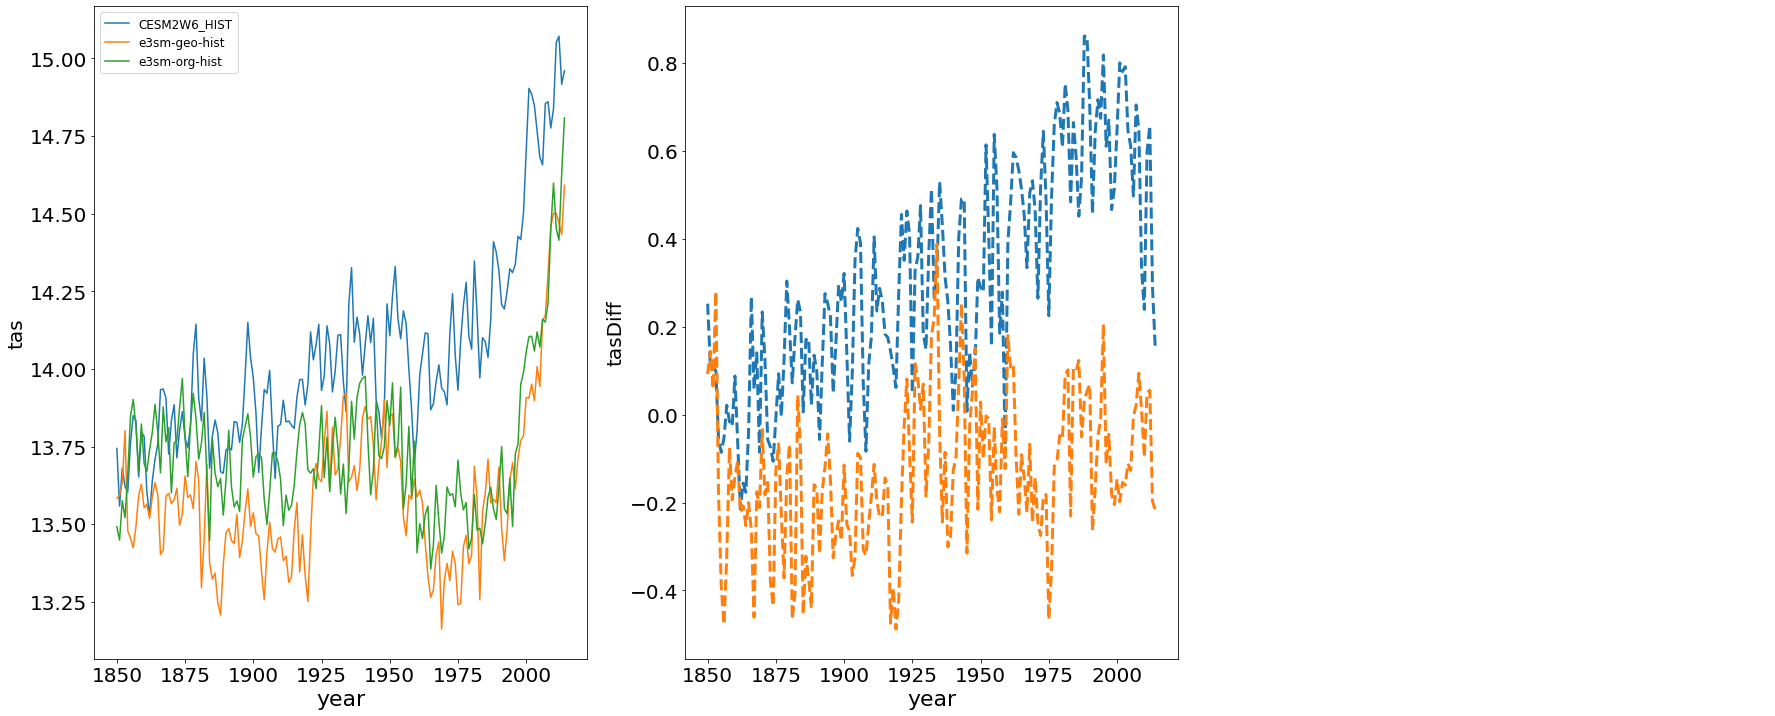

In [24]:
 plot_ts('hist', 'Amon', 'avg', 'tas', 1.0, -273.15, False, 'tas', noLimit = False, Vname_E3SM='TREFHT', Sca_E3SM=1.0, Fct_E3SM=-273.15)

['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/pr/gn/v20190227/pr_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc', '/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/pr/gn/v20190415/pr_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190415 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/pr/gn/v20190415/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/pr/gn/v20190415/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/atm/PRECSL_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/atm/PRECSL_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/atm/PRECL_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_ge

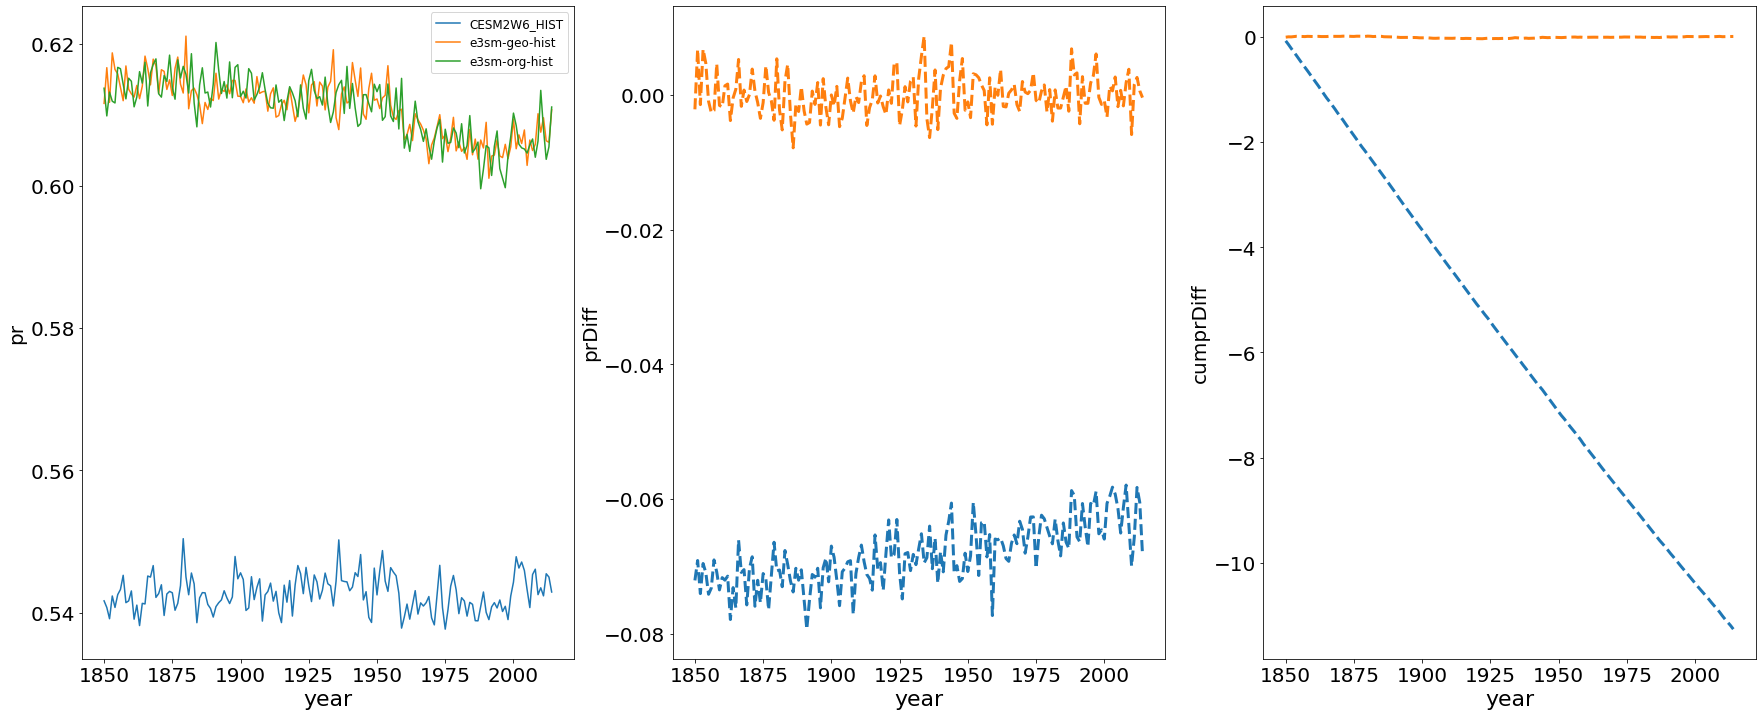

In [44]:
plot_ts('hist', 'Amon', 'sum', 'pr', 1.0e-3, 0.0, True, 'pr', noLimit = False, Vname_E3SM='PRECC+PRECL+PRECSC+PRECSL', Sca_E3SM=1.0, Fct_E3SM=0.0)

['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/gpp/gn/v20190227/gpp_Lmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/gpp/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/gpp/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/lnd/GPP_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/lnd/GPP_*.nc
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/fx/areacella/gn/v20190227/areacella_fx_CESM2-WACCM_historical_r1i1p1f1_gn.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/fx/areacella/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf

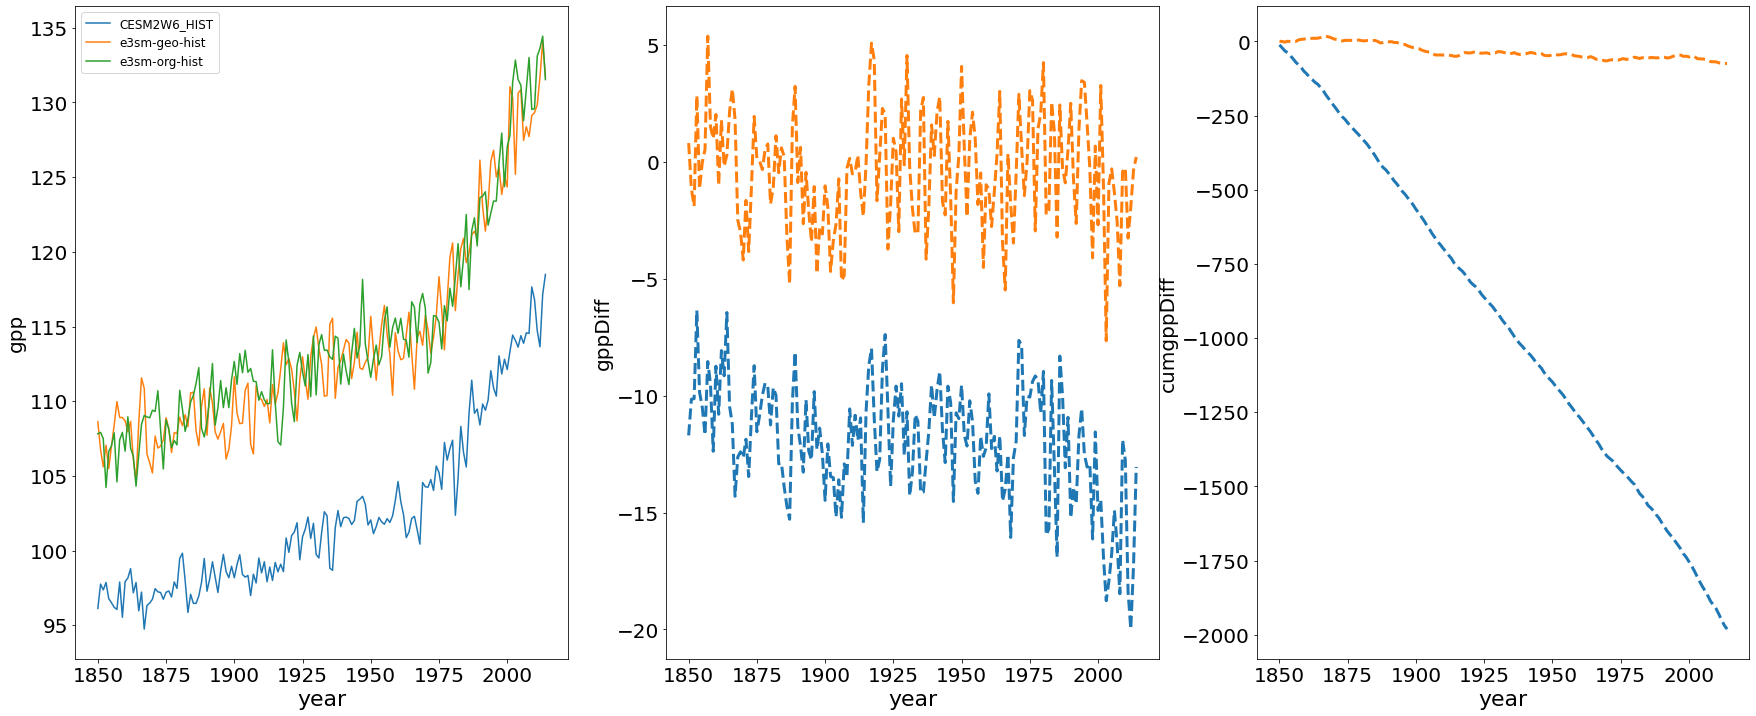

In [58]:
plot_ts('hist', 'Lmon', 'sum', 'gpp', 1000, 0.0, True, 'gpp', noLimit = False, Vname_E3SM='GPP', Sca_E3SM=1.0, Fct_E3SM=0.0)

['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/nbp/gn/v20190227/nbp_Lmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/nbp/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/nbp/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/lnd/NEE_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/lnd/NEE_*.nc
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/fx/areacella/gn/v20190227/areacella_fx_CESM2-WACCM_historical_r1i1p1f1_gn.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/fx/areacella/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf

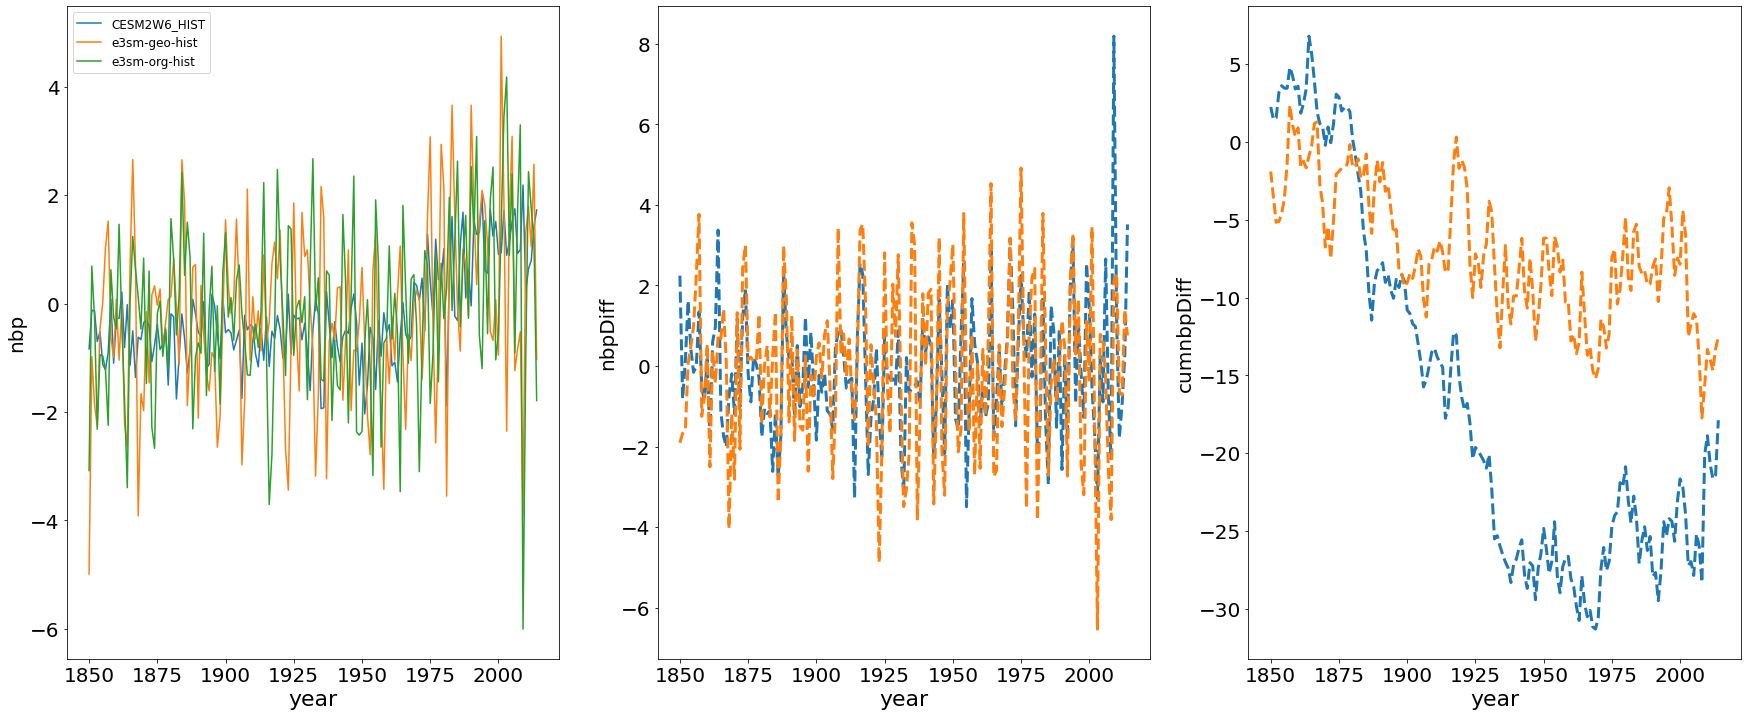

In [121]:
plot_ts('hist', 'Lmon', 'sum', 'nbp', 1000, 0.0, True, 'nbp', noLimit = False, Vname_E3SM='NEE', Sca_E3SM=-1.0, Fct_E3SM=0.0)

In [6]:
def _plot_geomap(daVarbsc, Sca_ESGF, OrigLevs, DiffLevs, VarName, Fct_ESGF=0.0, daVarbse=None, daVar20e=None, Sca_E3SM=None, Fct_E3SM=0.0, MaskOcean=False):
    
    # now all data are in:
    if Sca_E3SM:
        fig, ax = plt.subplots(3, 2, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=-180.)))
        fig.set_size_inches(18, 15)

    else:
        fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=-180.)))
        fig.set_size_inches(18, 28)

        
    MapTitles = ['(a) CESM2W6-HIST', '(b) CESM2W6-HIST minus E3SM-Org-HIST', '(c) E3SM-Geo-HIST', '(d) E3SM-Geo-HIST minus E3SM-Org-HIST', '(e) E3SM-Org-HIST']
    
    fo1 = (daVarbsc*Sca_ESGF+Fct_ESGF).plot(ax=ax[0,0], transform=ccrs.PlateCarree(), levels=OrigLevs, add_colorbar=False, cmap='viridis', extend='both')

    if Sca_E3SM: 
    
        daVarbse_interp = daVarbse.interp(lon=daVarbsc.lon, lat=daVarbsc.lat)
        fd1 = ((daVarbsc*Sca_ESGF+Fct_ESGF) - (daVarbse_interp*Sca_E3SM+Fct_E3SM)).plot(ax=ax[0,1], transform=ccrs.PlateCarree(),add_colorbar=False, levels=DiffLevs, cmap='bwr', extend='both')

        (daVar20e*Sca_E3SM+Fct_E3SM).plot(ax=ax[1,0], transform=ccrs.PlateCarree(), add_colorbar=False, levels=OrigLevs, cmap='viridis',extend='both')
        ((daVar20e*Sca_E3SM)-(daVarbse*Sca_E3SM)).plot(ax=ax[1,1], transform=ccrs.PlateCarree(), add_colorbar=False, levels=DiffLevs, cmap='bwr', extend='both')
 
        
        (daVarbse*Sca_E3SM+Fct_E3SM).plot(ax=ax[2,0], transform=ccrs.PlateCarree(), add_colorbar=False, levels=OrigLevs, cmap='viridis',extend='both')
        ax[2,1].axis('off')
        
    else:
        ax[0,1].axis('off')
    
    #remove the x and y labels
    for k, fax in enumerate(ax.flatten()):
        
        if fax == ax[2,1]: # or (Sca_E3SM and fax == ax[5,1]):
            pass
        else:       
            fax.set_xlabel('')
            fax.set_ylabel('')
            fax.set_global()
            fax.coastlines()
            
            if MaskOcean:
                fax.add_feature(cart.feature.OCEAN, zorder=100, facecolor='w')
                fax.add_feature(cart.feature.COASTLINE, zorder=200, edgecolor='k')
            fax.set_title(MapTitles[k] + ":" + VarName, fontsize=18)
            

    cbar_ax1 = fig.add_axes([0.20, 0.04, 0.22, 0.01])
    cbar1 = fig.colorbar(fo1, cax=cbar_ax1, orientation="horizontal", extendrect=True)
    cbar1.ax.tick_params(labelsize=16)
    
    cbar_ax2 = fig.add_axes([0.60, 0.33, 0.22, 0.01])
    cbar2 = fig.colorbar(fd1, cax=cbar_ax2, orientation="horizontal", extendrect=True)
    cbar2.ax.tick_params(labelsize=16)
    plt.subplots_adjust(hspace=0.1, wspace=0.05, bottom=0.05)


In [7]:
### set up a common geographical map for some key variables:
import sys
def plot_geomap(SecName, TabName, OpType, Vname_ESGF, Sca_ESGF, Cumdiff, Ylabel, OrigLevs, DiffLevs, YrRange, noLimit = False, Vname_E3SM=None, Sca_E3SM=None, MskOcn=False):
    opstr = ['+', '-', '*', '/']

    print (OrigLevs)
    

## ESGF
    if any (e in Vname_ESGF for e in opstr):
        Sym_Expr_ESGF = sympify(Vname_ESGF)
        FreeSymb_ESGF = list(Sym_Expr_ESGF.free_symbols)
        fESGF = lambdify(FreeSymb_ESGF, Sym_Expr_ESGF, "numpy")

        dsTmpbs = []
        for s in FreeSymb_ESGF:
            dsTmpbs.append(open_files('esgf', SecName.lower(), TabName, '',           s.name))
        dsVarbs = dsTmpbs[0].copy()
        dsVarbs["uniqName"] = fESGF(*[ds[s.name] for s, ds in zip(FreeSymb_ESGF,dsTmpbs)])        
        if not noLimit:
            dsVarbs["uniqName"] = dsVarbs["uniqName"].where(np.logical_and(dsVarbs["uniqName"] > 0, dsVarbs["uniqName"] < 1)) 
        vesgf = 'uniqName'
 
    else:
        if Vname_ESGF == 'tas':
            dsVarbs = open_files('esgf', SecName.lower(), 'Amon', '',           Vname_ESGF)
        else:
            dsVarbs = open_files('esgf', SecName.lower(), TabName, '',           Vname_ESGF)
        vesgf = Vname_ESGF

    if Vname_E3SM: 
        if any (e in Vname_E3SM for e in opstr):
            Sym_Expr_E3SM = sympify(Vname_E3SM)
            FreeSymb_E3SM = list(Sym_Expr_E3SM.free_symbols)
            fE3SM = lambdify(FreeSymb_E3SM, Sym_Expr_E3SM, "numpy")

            dsTmpbs = []
            dsTmp20 = []
            for s in FreeSymb_E3SM:
                dsTmp20.append(open_files('e3sm', SecName.lower(), TabName, E3SM_Geo_HIST, s.name))
                dsTmpbs.append(open_files('e3sm', SecName.lower(), TabName, E3SM_Org_HIST, s.name))

            dsVar20e = dsTmp20[0].copy()
            dsVarbse = dsTmpbs[0].copy()
            dsVar20e["uniqName"] = fE3SM(*[ds[s.name] for s, ds in zip(FreeSymb_E3SM,dsTmp20)])
            dsVarbse["uniqName"] = fE3SM(*[ds[s.name] for s, ds in zip(FreeSymb_E3SM,dsTmpbs)])
        
            if not noLimit:
                dsVar20e["uniqName"] = dsVar20e["uniqName"].where(np.logical_and(dsVar20e["uniqName"] > 0, dsVar20e["uniqName"] < 1))
                dsVarbse["uniqName"] = dsVarbse["uniqName"].where(np.logical_and(dsVarbse["uniqName"] > 0, dsVarbse["uniqName"] < 1))
            ve3sm = 'uniqName'
        else:
            dsVar20e = open_files('e3sm', SecName.lower(), TabName, E3SM_Geo_HIST, Vname_E3SM)
            dsVarbse = open_files('e3sm', SecName.lower(), TabName, E3SM_Org_HIST, Vname_E3SM)
            ve3sm = Vname_E3SM
            
    #StrtYear = '1850-01-01'
    #StopYear = '1900-12-31'
    
    StrtYear = str(YrRange[0]) + '-01-01'
    StopYear = str(YrRange[1]) + '-12-31'
    
    Ylabel = Ylabel + ":{}-{}".format(str(YrRange[0]), str(YrRange[1]))
    
    if OpType == 'sum':

        daVarbs   = SumVar(dsVarbs  , vesgf, StrtYear, StopYear, TabName, TimeShift = False)
        
        if Vname_E3SM:            
            daVar20e = SumVar(dsVar20e, ve3sm, StrtYear, StopYear, TabName)
            daVarbse = SumVar(dsVarbse, ve3sm, StrtYear, StopYear, TabName)
    elif OpType == 'avg':
        

        daVarbs   = AvgVar(dsVarbs  , vesgf, StrtYear, StopYear, TabName, TimeShift = False)
        
        
        #areacella = open_files('esgf', SecName.lower()+'-over', 'fx', '', 'areacella')*1.e-6
        #sftlf = open_files('esgf', SecName.lower()+'-over', 'fx', '', 'sftlf') *1.e-2
        #Var15_1_TsGBL = gm_by_area_wght(dsVar15_1.sel(time=slice(StrtYear, StopYear)), Vname_NCAR, OpType, False, areacella, sftlf, TabName) * Sca_NCAR
        #Varbs_TsGBL = gm_by_area_wght(dsVarbs.sel(time=slice(StrtYear, StopYear)), Vname_ESGF, OpType, False, areacella, sftlf, TabName, TimeShift=False) * Sca_ESGF
        
        
        if Vname_E3SM:
            #E3SM_areacella = open_files('e3sm', SecName.lower()+'-over', 'fx', E3SM_Geo_HIST, 'areacella')*1.e-6
            #E3SM_sftlf = open_files('e3sm', SecName.lower()+'-over', 'fx', E3SM_Geo_HIST, 'sftlf')*1.e-2
            #Varbse_TsGBL = gm_by_area_wght(dsVarbse, Vname_E3SM, OpType, False, E3SM_areacella, E3SM_sftlf, TabName, TimeShift=True) * Sca_E3SM
            #Varbse_TsGBL = dsVarbse.TREFHT.mean(dim=("lat", "lon"))
            
            daVar20e = AvgVar(dsVar20e, ve3sm, StrtYear, StopYear, TabName)
            daVarbse = AvgVar(dsVarbse, ve3sm, StrtYear, StopYear, TabName)  

    if Vname_E3SM:
        _plot_geomap(daVarbs, Sca_ESGF, OrigLevs, DiffLevs, Ylabel, daVarbse=daVarbse, daVar20e=daVar20e, Sca_E3SM=Sca_E3SM, MaskOcean=MskOcn)
    else:
        _plot_geomap(daVarbs, Sca_ESGF, OrigLevs, DiffLevs, Ylabel, daVarbse=None, daVar20e=None, Sca_E3SM=Sca_E3SM, MaskOcean=MskOcn)

    
def SumVar(dsVar, vname, syr, eyr, TabName, TimeShift=True):

    if TimeShift:
        if TabName == 'Lmon':
            dsVar["time0"] = dsVar.time_bounds[:,0].dt.ceil('D')
        if TabName == 'Amon':
            dsVar["time0"] = dsVar.time_bnds[:,0]

        dd = dsVar.set_index(time="time0")
        
    else:
        dd = dsVar 
    return (dd[vname] * dd.time.dt.days_in_month * 86400).sel(time=slice(syr,eyr)).groupby('time.year').sum(dim='time').mean(dim='year')

def AvgVar(dsVar, vname, syr, eyr, TabName, TimeShift=True):
    if TimeShift:
        if TabName == 'Lmon':
            dsVar["time0"] = dsVar.time_bounds[:,0].dt.ceil('D')
        if TabName == 'Amon':
            dsVar["time0"] = dsVar.time_bnds[:,0]

        dd = dsVar.set_index(time="time0")
        
    else:
        dd = dsVar 
    
    return (dd[vname] * dd.time.dt.days_in_month/365.).sel(time=slice(syr,eyr)).groupby('time.year').sum(dim='time').mean(dim='year')

[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4 7.2 8. ]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/pr/gn/v20190227/pr_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc', '/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/pr/gn/v20190415/pr_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190415 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/pr/gn/v20190415/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/pr/gn/v20190415/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/atm/PRECSL_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/atm/PRECSL_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/atm/PRECL_*.n

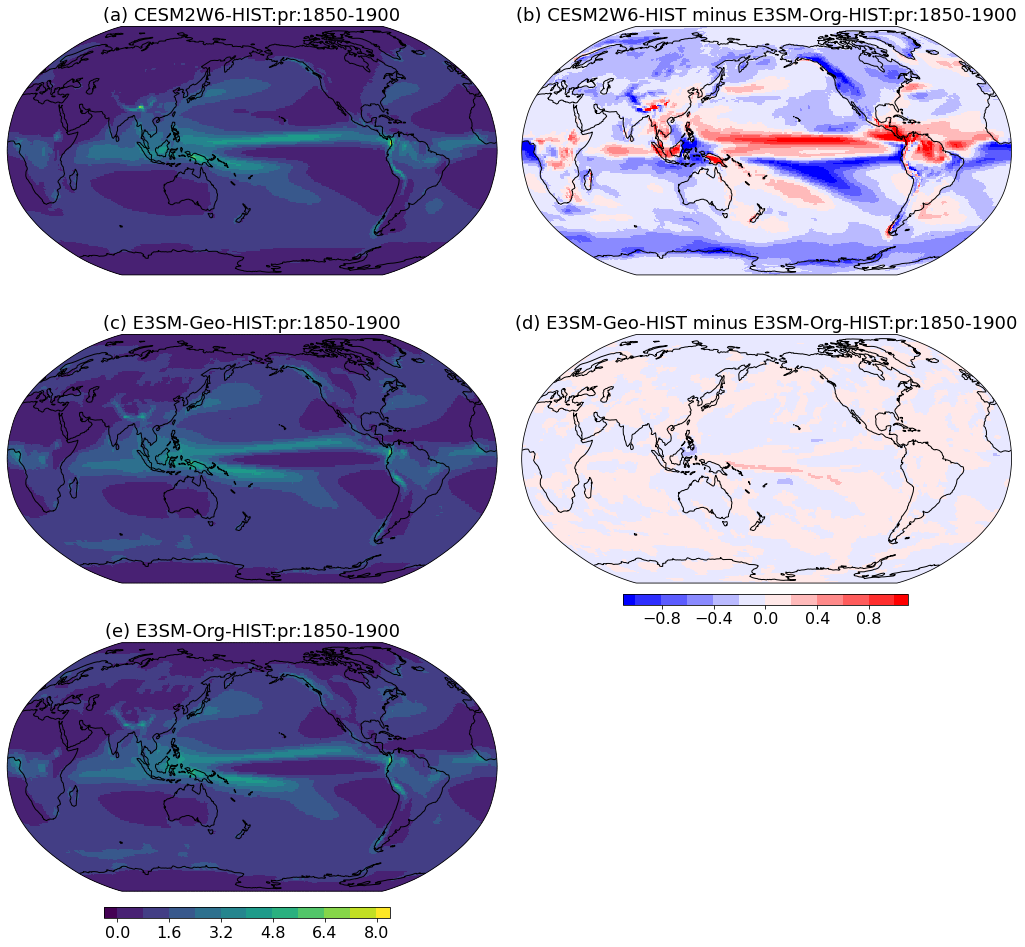

In [117]:
OLevs = np.linspace(0, 8, 11)
DLevs = np.linspace(-1, 1, 11)

plot_geomap('hist', 'Amon', 'sum', 'pr', 1.0e-3, True, 'pr', OLevs, DLevs, [1850,1900], noLimit = False, Vname_E3SM='PRECC+PRECL+PRECSC+PRECSL', Sca_E3SM=1.0)


[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4 7.2 8. ]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/pr/gn/v20190227/pr_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc', '/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/pr/gn/v20190415/pr_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190415 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/pr/gn/v20190415/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/pr/gn/v20190415/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/atm/PRECSL_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/atm/PRECSL_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/atm/PRECL_*.n

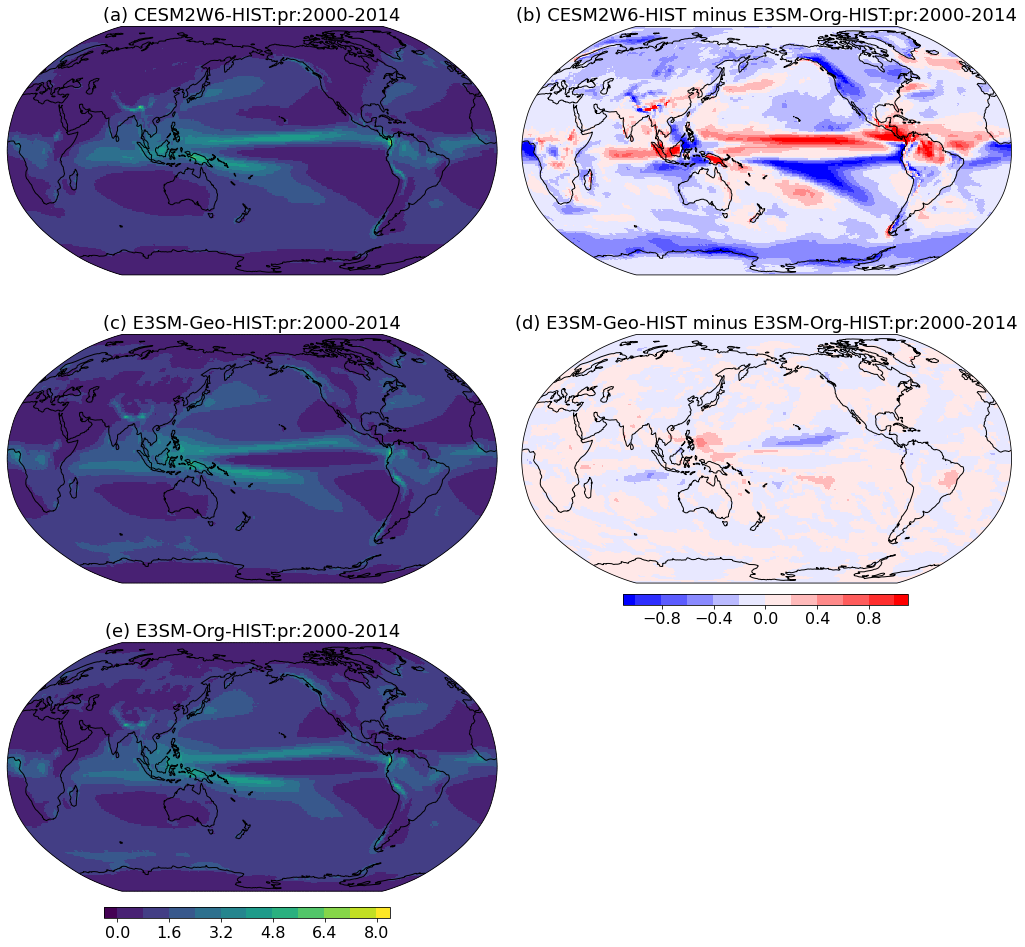

In [126]:
OLevs = np.linspace(0, 8, 11)
DLevs = np.linspace(-1, 1, 11)

plot_geomap('hist', 'Amon', 'sum', 'pr', 1.0e-3, True, 'pr', OLevs, DLevs, [2000,2014], noLimit = False, Vname_E3SM='PRECC+PRECL+PRECSC+PRECSL', Sca_E3SM=1.0)

[240. 246. 252. 258. 264. 270. 276. 282. 288. 294. 300.]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/tas/gn/v20190227/tas_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/tas/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/tas/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/atm/TREFHT_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/atm/TREFHT_*.nc


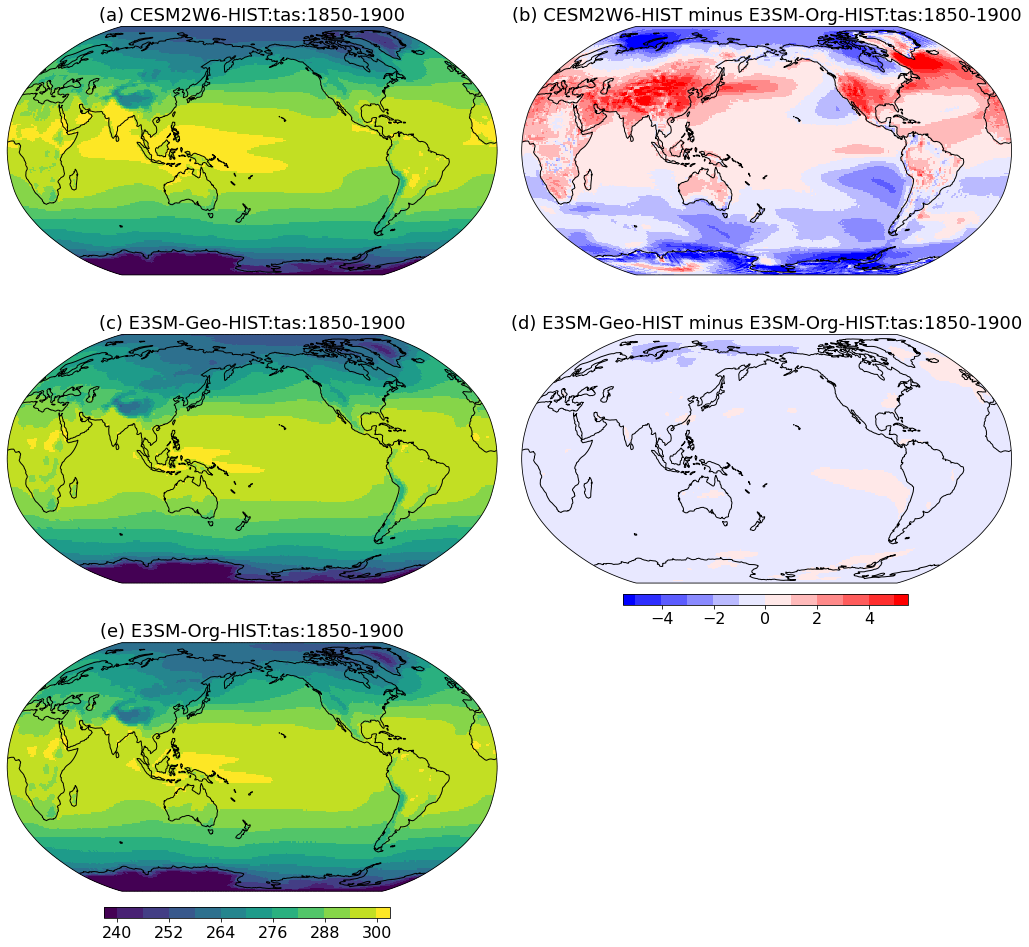

In [128]:
OLevs = np.linspace(240, 300, 11)
DLevs = np.linspace(-5, 5, 11)

plot_geomap('hist', 'Amon', 'avg', 'tas', 1.0, True, 'tas', OLevs, DLevs, [1850,1900], noLimit = False, Vname_E3SM='TREFHT', Sca_E3SM=1.0)

[240. 246. 252. 258. 264. 270. 276. 282. 288. 294. 300.]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/tas/gn/v20190227/tas_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/tas/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/tas/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/atm/TREFHT_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/atm/TREFHT_*.nc


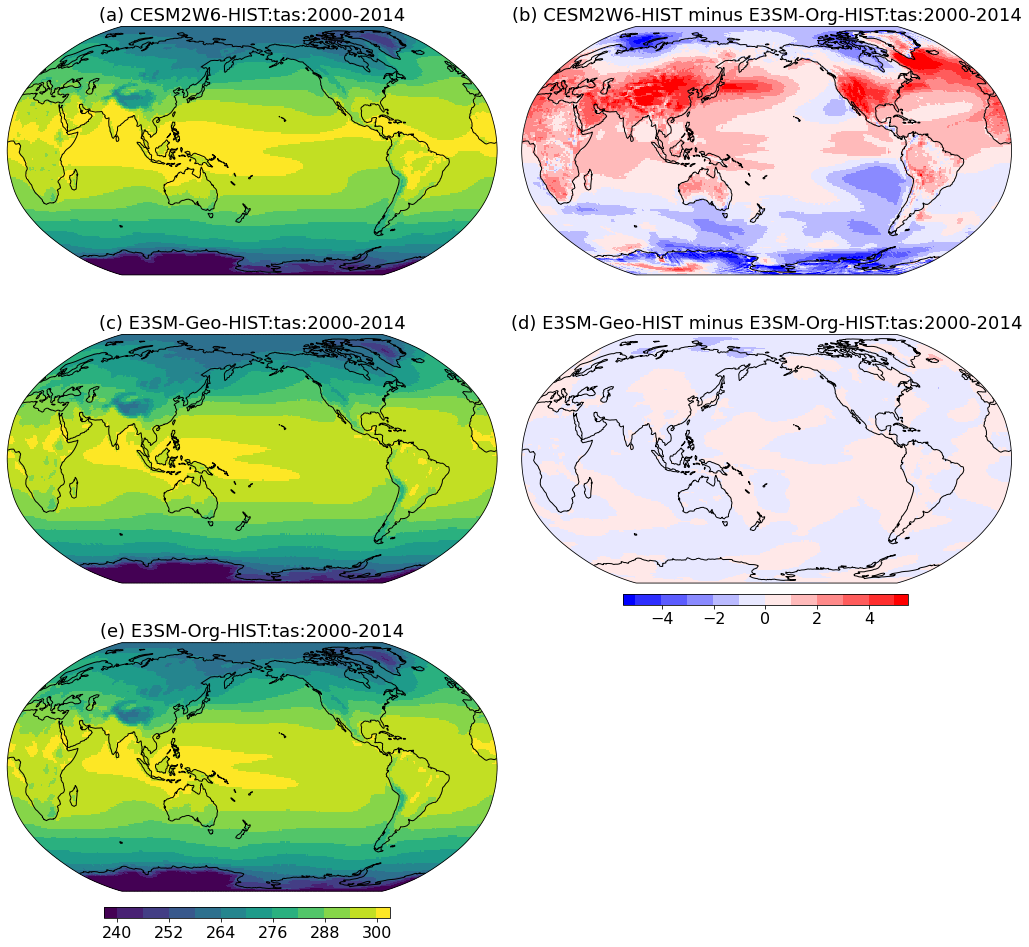

In [129]:
OLevs = np.linspace(240, 300, 11)
DLevs = np.linspace(-5, 5, 11)

plot_geomap('hist', 'Amon', 'avg', 'tas', 1.0, True, 'tas', OLevs, DLevs, [2000,2014], noLimit = False, Vname_E3SM='TREFHT', Sca_E3SM=1.0)

[ 60.  78.  96. 114. 132. 150. 168. 186. 204. 222. 240.]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/rsds/gn/v20190227/rsds_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/rsds/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/rsds/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/atm/FSDS_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/atm/FSDS_*.nc


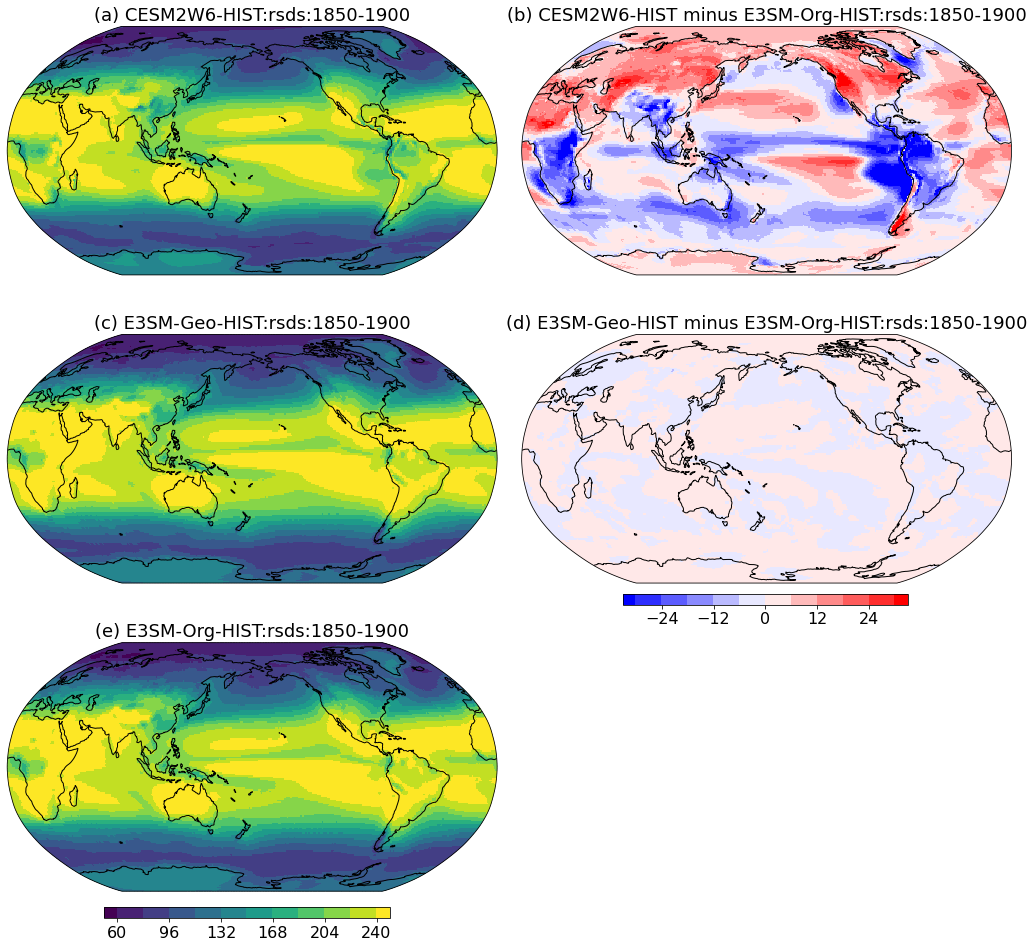

In [130]:
OLevs = np.linspace(60, 240, 11)
DLevs = np.linspace(-30, 30, 11)
plot_geomap('hist', 'Amon', 'avg', 'rsds', 1.0, True, 'rsds', OLevs, DLevs, [1850,1900], noLimit = False, Vname_E3SM='FSDS', Sca_E3SM=1.0)

[ 60.  78.  96. 114. 132. 150. 168. 186. 204. 222. 240.]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/rsds/gn/v20190227/rsds_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/rsds/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/rsds/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/atm/FSDS_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/atm/FSDS_*.nc


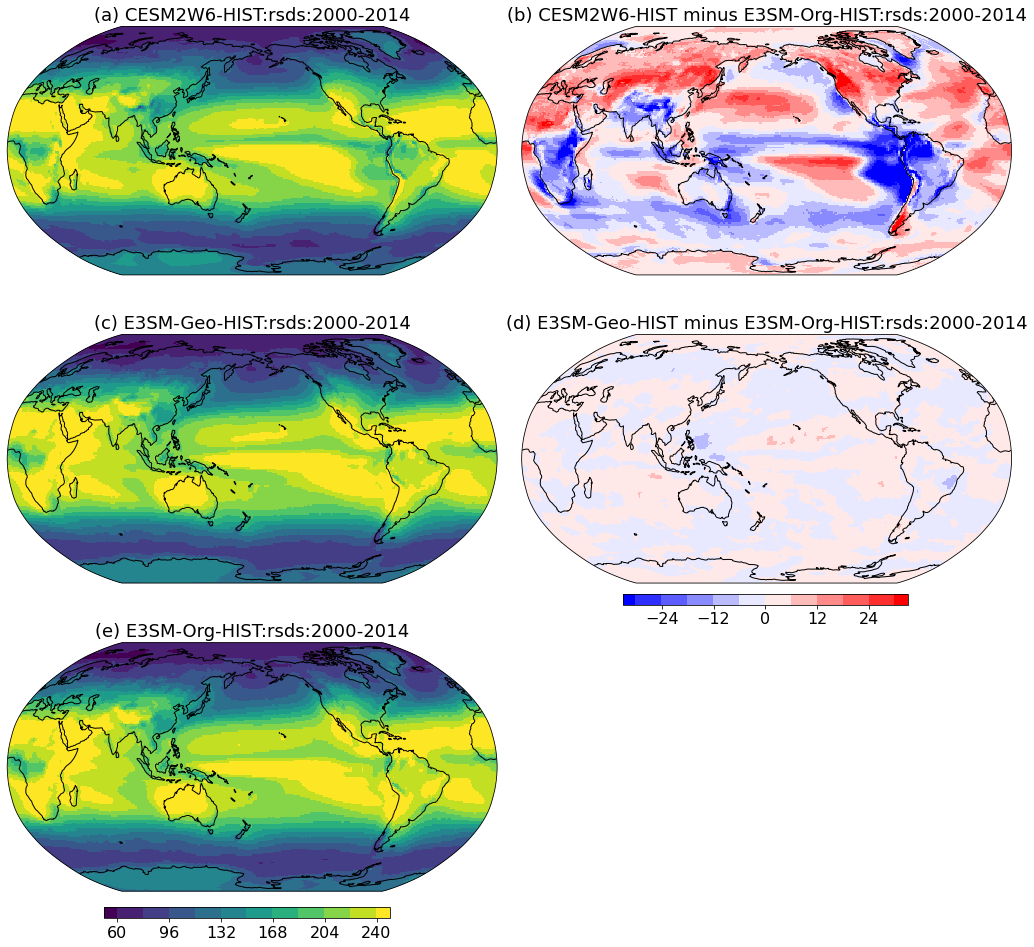

In [131]:
OLevs = np.linspace(60, 240, 11)
DLevs = np.linspace(-30, 30, 11)
plot_geomap('hist', 'Amon', 'avg', 'rsds', 1.0, True, 'rsds', OLevs, DLevs, [2000,2014], noLimit = False, Vname_E3SM='FSDS', Sca_E3SM=1.0)

[100. 120. 140. 160. 180. 200. 220. 240. 260. 280. 300.]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/rlds/gn/v20190227/rlds_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/rlds/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/rlds/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/atm/FLDS_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/atm/FLDS_*.nc


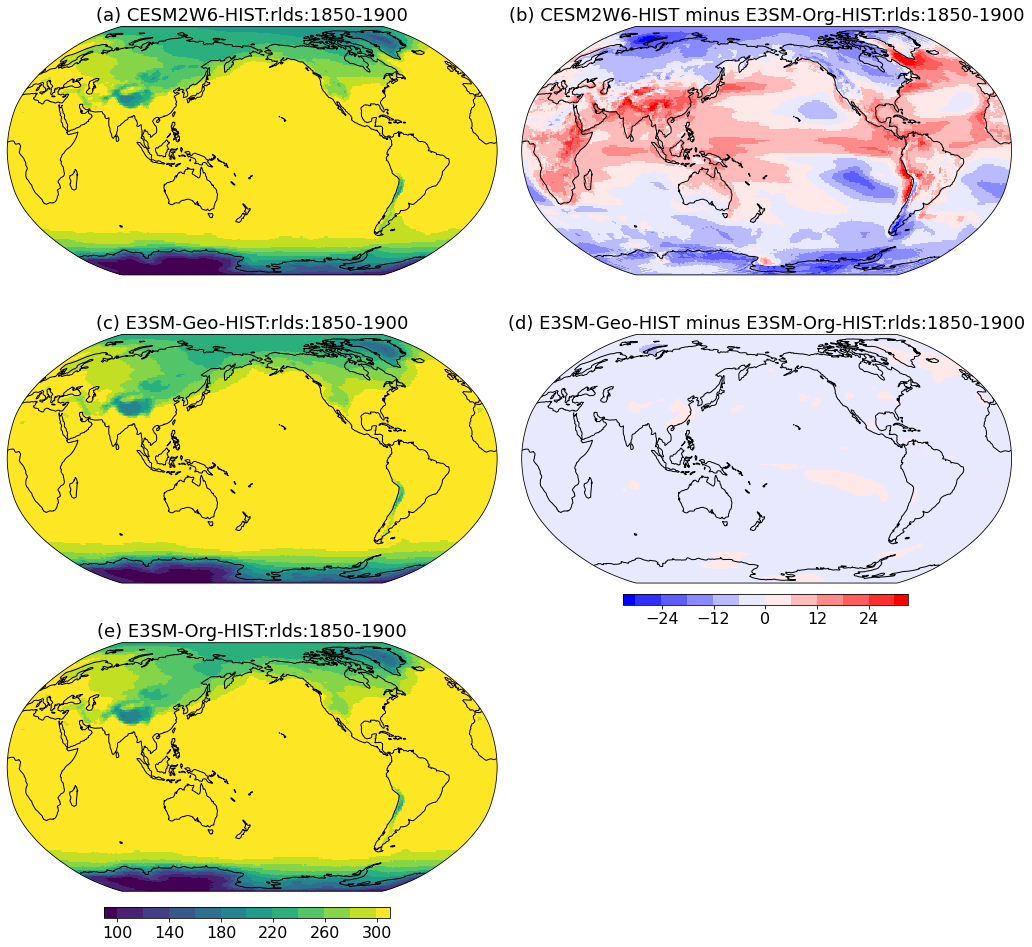

In [10]:
OLevs = np.linspace(100, 300, 11)
DLevs = np.linspace(-30, 30, 11)
plot_geomap('hist', 'Amon', 'avg', 'rlds', 1.0, True, 'rlds', OLevs, DLevs, [1850,1900], noLimit = False, Vname_E3SM='FLDS', Sca_E3SM=1.0)

[100. 120. 140. 160. 180. 200. 220. 240. 260. 280. 300.]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/rlds/gn/v20190227/rlds_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/rlds/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Amon/rlds/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/atm/FLDS_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/atm/FLDS_*.nc


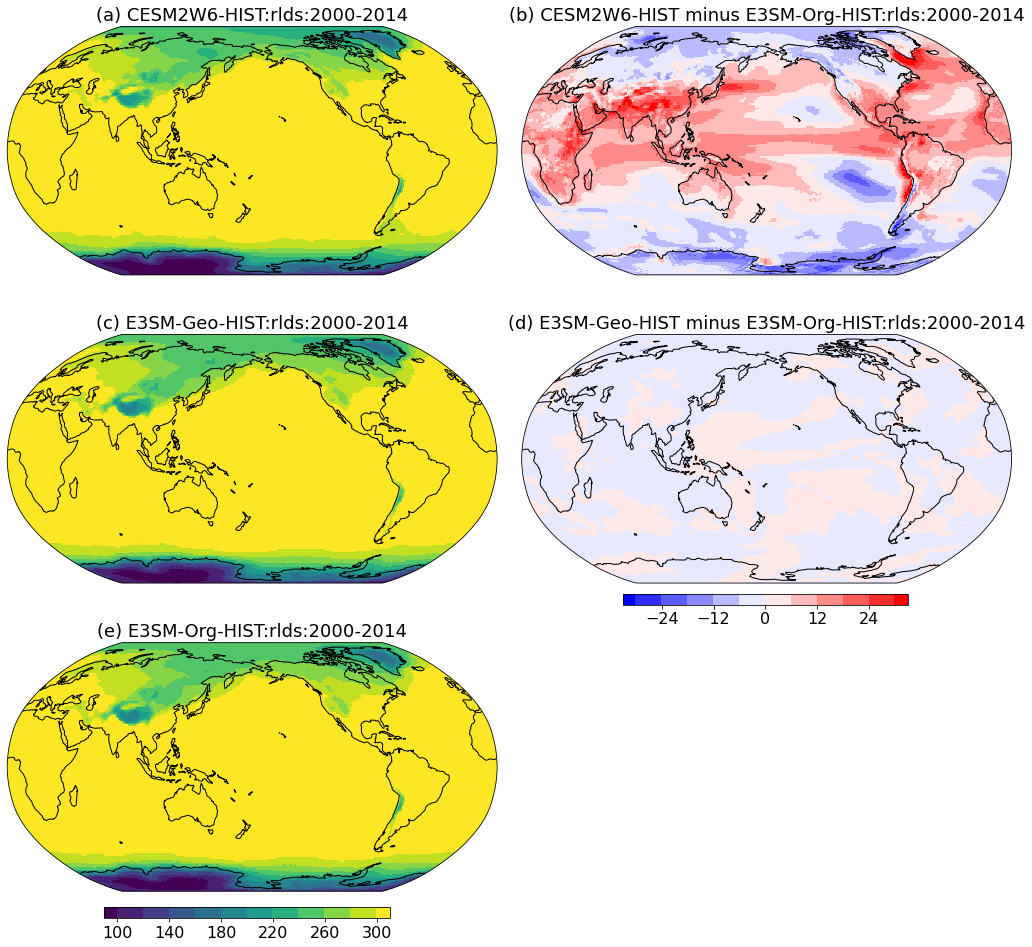

In [9]:
OLevs = np.linspace(100, 300, 11)
DLevs = np.linspace(-30, 30, 11)
plot_geomap('hist', 'Amon', 'avg', 'rlds', 1.0, True, 'rlds', OLevs, DLevs, [2000,2014], noLimit = False, Vname_E3SM='FLDS', Sca_E3SM=1.0)

[   0.  400.  800. 1200. 1600. 2000. 2400. 2800. 3200. 3600. 4000.]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/gpp/gn/v20190227/gpp_Lmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/gpp/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/gpp/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/lnd/GPP_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/lnd/GPP_*.nc


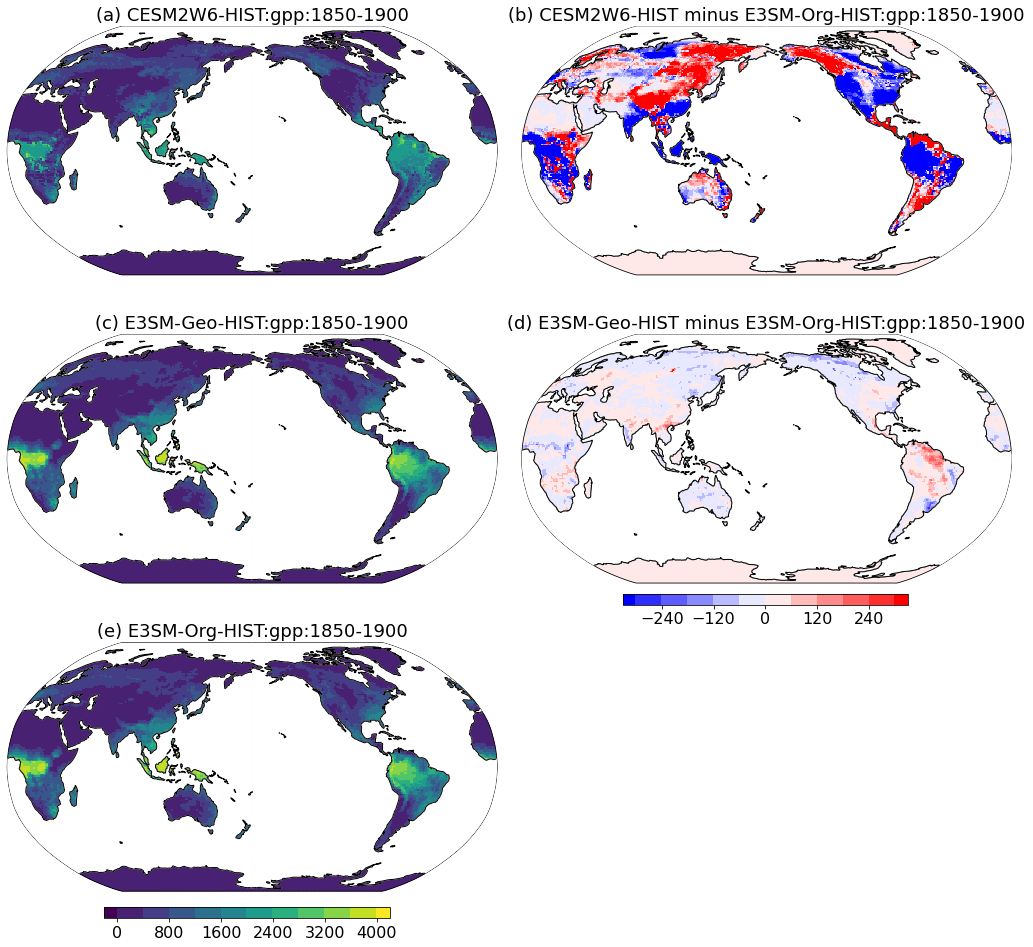

In [118]:
OLevs = np.linspace(0, 4000, 11)
DLevs = np.linspace(-300, 300, 11)

plot_geomap('hist', 'Lmon', 'sum', 'gpp', 1000.0, True, 'gpp', OLevs, DLevs, [1850,1900], noLimit = False, Vname_E3SM='GPP', Sca_E3SM=1.0, MskOcn=True)

[   0.  400.  800. 1200. 1600. 2000. 2400. 2800. 3200. 3600. 4000.]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/gpp/gn/v20190227/gpp_Lmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/gpp/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/gpp/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/lnd/GPP_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/lnd/GPP_*.nc


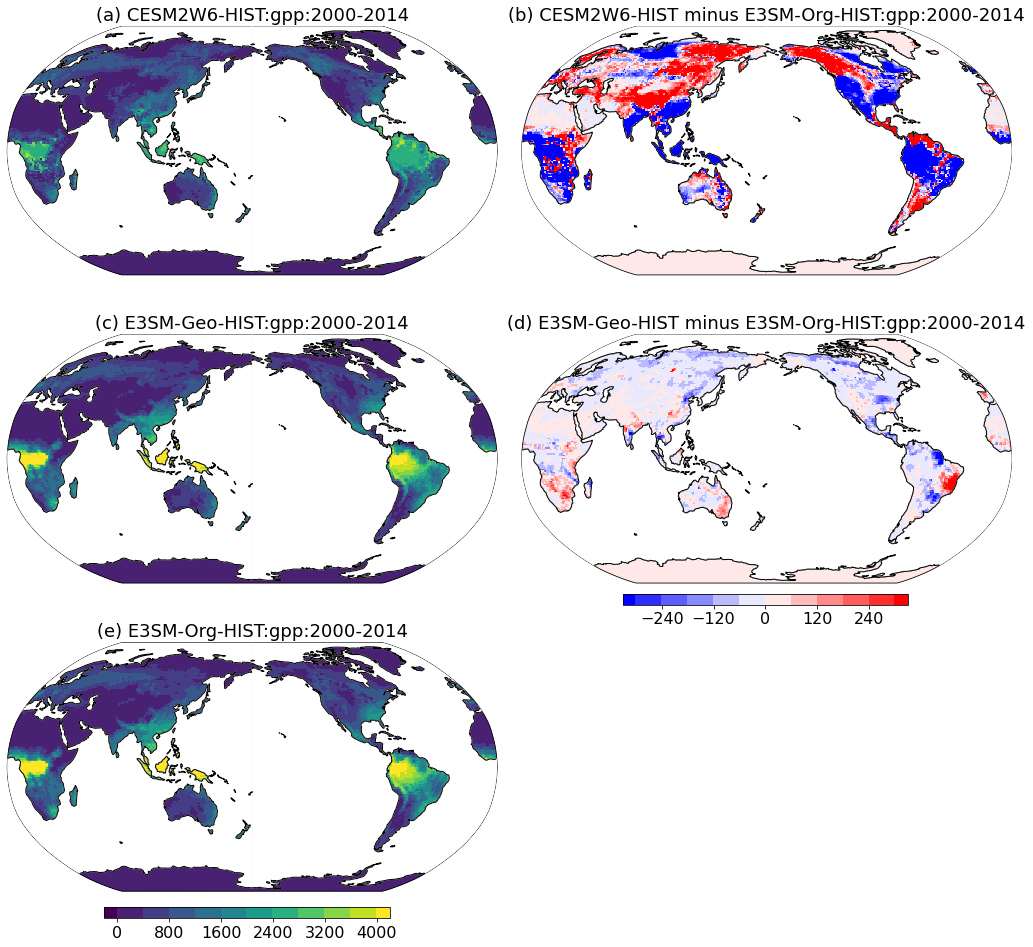

In [127]:
OLevs = np.linspace(0, 4000, 11)
DLevs = np.linspace(-300, 300, 11)

plot_geomap('hist', 'Lmon', 'sum', 'gpp', 1000.0, True, 'gpp', OLevs, DLevs, [2000,2014], noLimit = False, Vname_E3SM='GPP', Sca_E3SM=1.0, MskOcn=True)

[   0.  160.  320.  480.  640.  800.  960. 1120. 1280. 1440. 1600.]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/npp/gn/v20190227/npp_Lmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/npp/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/npp/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/lnd/NPP_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/lnd/NPP_*.nc


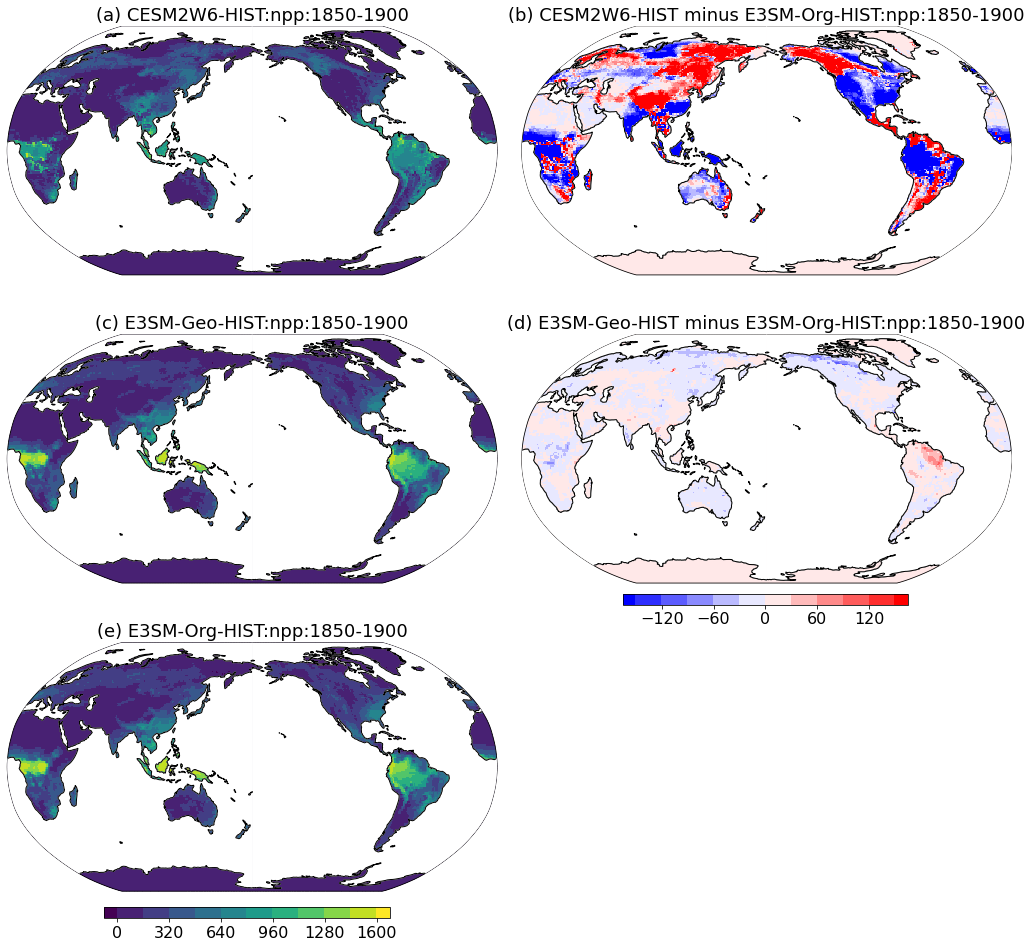

In [119]:
OLevs = np.linspace(0, 1600, 11)
DLevs = np.linspace(-150, 150, 11)

plot_geomap('hist', 'Lmon', 'sum', 'npp', 1000.0, True, 'npp', OLevs, DLevs, [1850,1900], noLimit = False, Vname_E3SM='NPP', Sca_E3SM=1.0, MskOcn=True)

[   0.  160.  320.  480.  640.  800.  960. 1120. 1280. 1440. 1600.]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/nbp/gn/v20190227/nbp_Lmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/nbp/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/nbp/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/lnd/NEE_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/lnd/NEE_*.nc


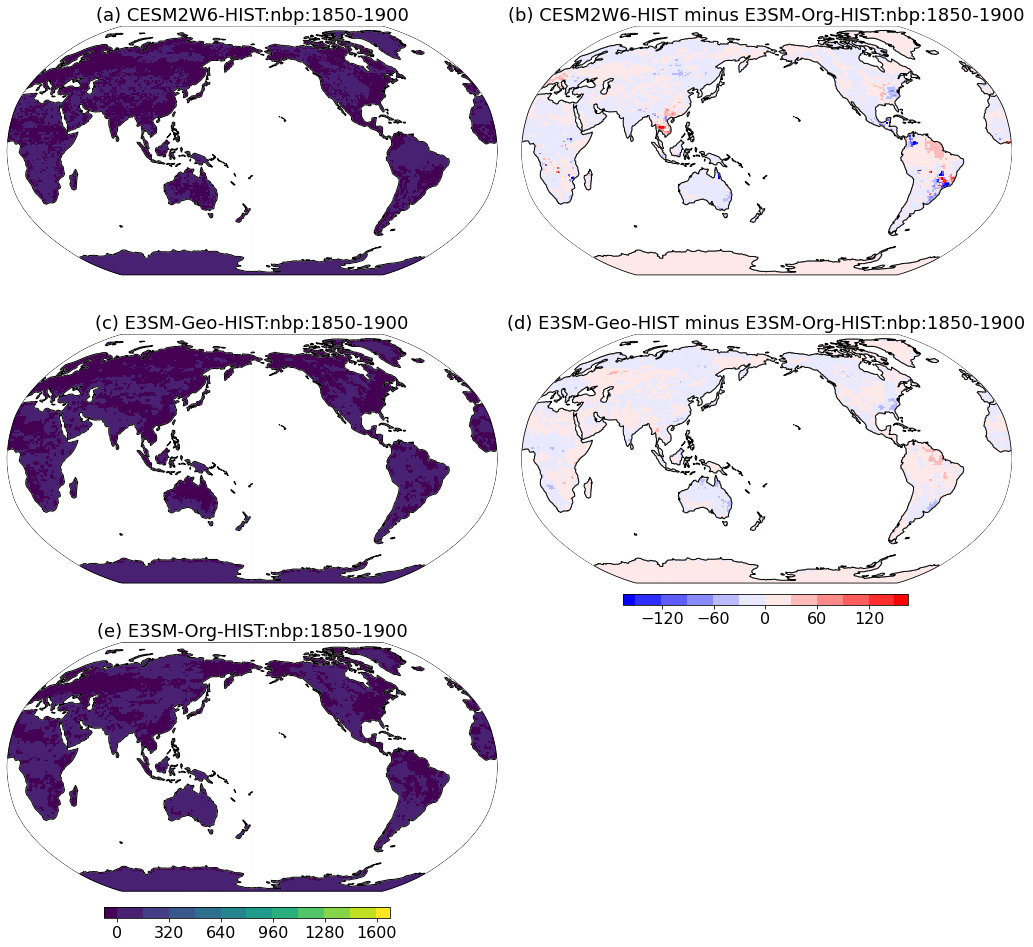

In [120]:
OLevs = np.linspace(0, 1600, 11)
DLevs = np.linspace(-150, 150, 11)

plot_geomap('hist', 'Lmon', 'sum', 'nbp', 1000.0, True, 'nbp', OLevs, DLevs, [1850,1900], noLimit = False, Vname_E3SM='NEE', Sca_E3SM=-1.0, MskOcn=True)

[   0.  160.  320.  480.  640.  800.  960. 1120. 1280. 1440. 1600.]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/ra/gn/v20190227/ra_Lmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/ra/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/ra/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/lnd/AR_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/lnd/AR_*.nc


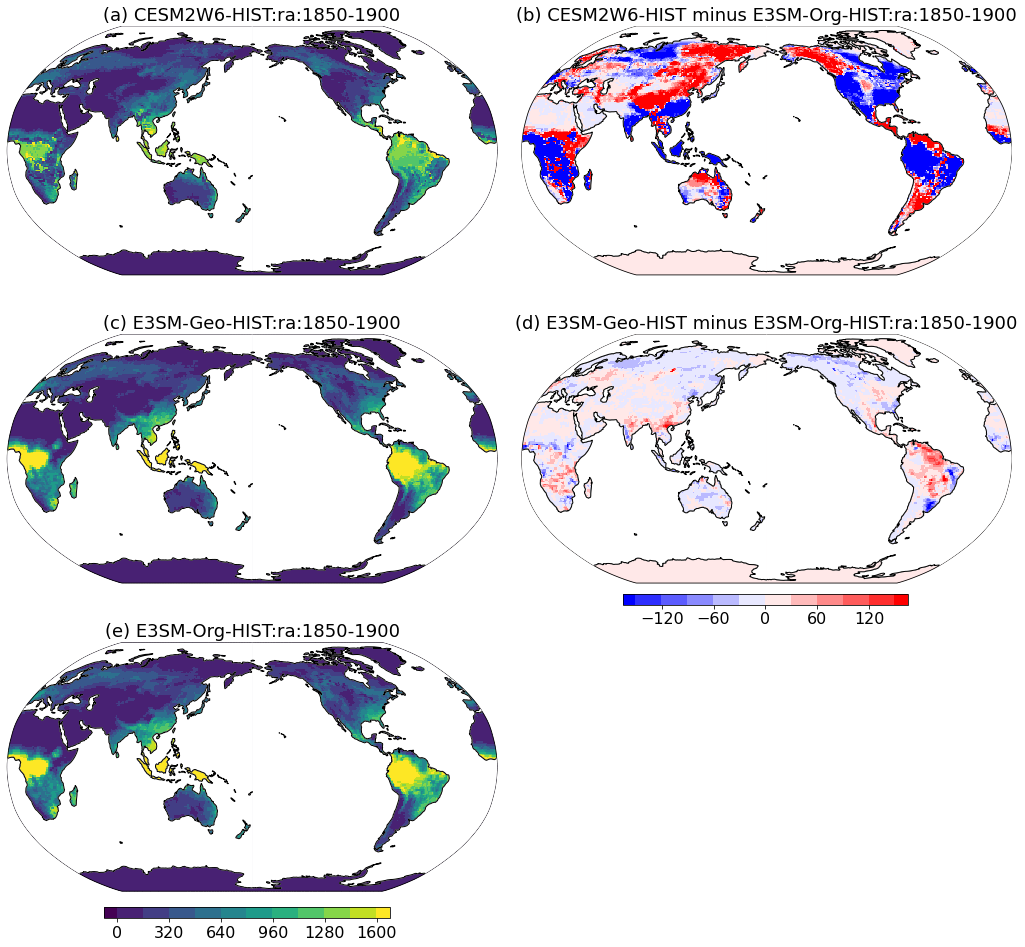

In [124]:
OLevs = np.linspace(0, 1600, 11)
DLevs = np.linspace(-150, 150, 11)

plot_geomap('hist', 'Lmon', 'sum', 'ra', 1000.0, True, 'ra', OLevs, DLevs, [1850,1900], noLimit = False, Vname_E3SM='AR', Sca_E3SM=1.0, MskOcn=True)

[   0.  160.  320.  480.  640.  800.  960. 1120. 1280. 1440. 1600.]
['/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/rh/gn/v20190227/rh_Lmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']
v20190227 /gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/rh/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/cesm2_waccm/cesm2-waccm-esgf/hist/r1i1p1f1/Lmon/rh/gn/v20190227/*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220418.GEOENG_HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.miller/rgr/lnd/HR_*.nc
/gpfs/alpine/cli137/world-shared/mxu/e3sm_geo/20220102.HIST_RUBISCO_NEWSFLU_CNPCTC20TR_OIBGC.ne30_oECv3.compy/rgr/lnd/HR_*.nc


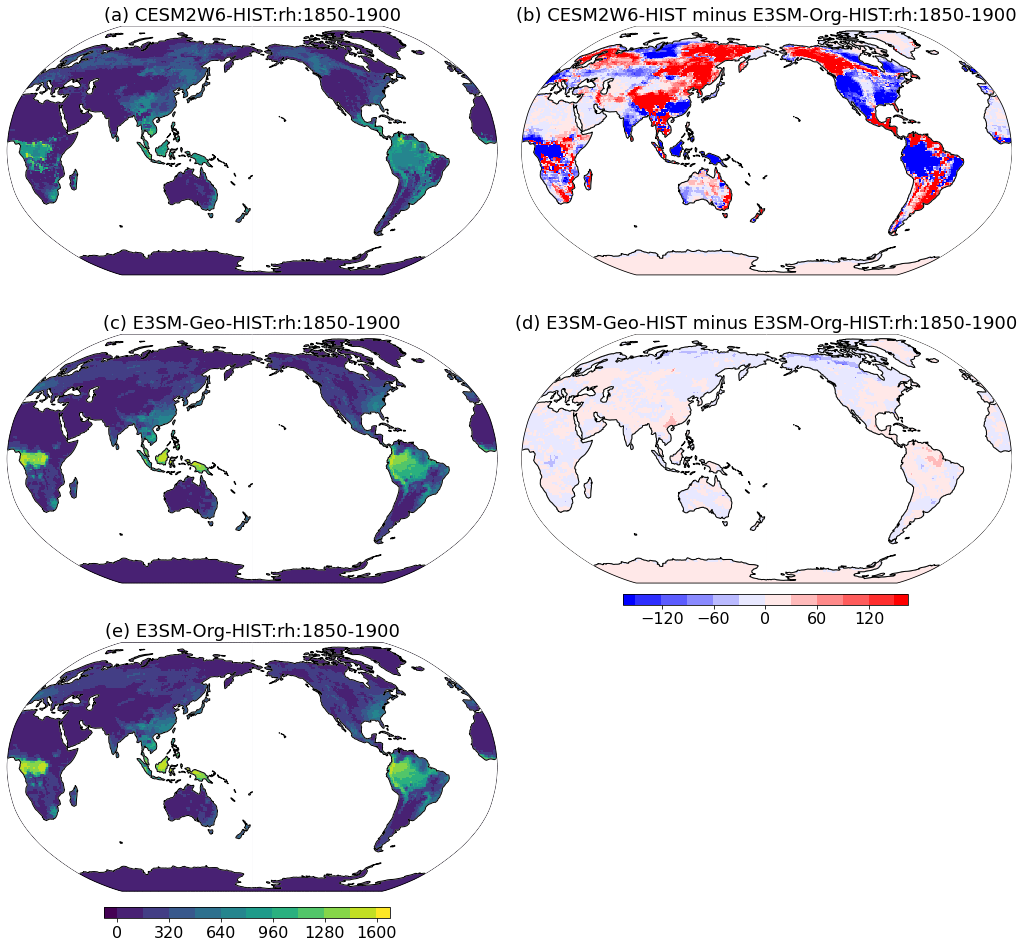

In [125]:
OLevs = np.linspace(0, 1600, 11)
DLevs = np.linspace(-150, 150, 11)

plot_geomap('hist', 'Lmon', 'sum', 'rh', 1000.0, True, 'rh', OLevs, DLevs, [1850,1900], noLimit = False, Vname_E3SM='HR', Sca_E3SM=1.0, MskOcn=True)